In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import joblib


In [30]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def preprocess_data(seq_length=10, test_size=2000):
    """
    Loads Lorenz data, scales it, and creates sliding windows.
    :param seq_length: Length of input sequences.
    :param test_size: Number of samples reserved for testing.
    :return: Fitted scaler.
    """
    df = pd.read_csv("data/lorenz_data.csv")
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length])
        y.append(data_scaled[i + seq_length])
    
    X = np.array(X)
    y = np.array(y)
    
    # Split the data: last 'test_size' samples for testing.
    if test_size < len(X):
        X_train = X[:-test_size]
        y_train = y[:-test_size]
        X_test = X[-test_size:]
        y_test = y[-test_size:]
    else:
        X_train, y_train, X_test, y_test = X, y, X, y

    os.makedirs("data", exist_ok=True)
    np.savez("data/processed_data.npz", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    joblib.dump(scaler, "data/scaler.pkl")
    print("✅ Data preprocessing complete. Processed data saved to 'data/processed_data.npz'")
    return scaler



In [5]:
scalar = preprocess_data()

✅ Data preprocessing complete. Processed data saved to 'data/processed_data.npz'


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


2026-01-16 08:45:23.481886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def build_lstm(seq_length=10, input_dim=3):
    """
    Builds and compiles an LSTM model with dropout for regularization.
    :param seq_length: Length of the input sequence.
    :param input_dim: Number of features (3 for the Lorenz system).
    :return: Compiled Keras model.
    """
    model = Sequential([
        LSTM(32, input_shape=(seq_length, input_dim), return_sequences=True),
        Dropout(0.2),
        LSTM(16),
        Dropout(0.2),
        Dense(3)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


In [8]:
model = build_lstm()

/Users/chedon/miniforge3/envs/cha/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,795 (30.45 KB)

 Trainable params: 7,795 (30.45 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Load processed data.
data = np.load("data/processed_data.npz")
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]


In [11]:
X_train

array([[[4.86668503e-01, 4.63347590e-01, 8.14075036e-04],
        [4.87013651e-01, 4.68666183e-01, 4.92416687e-04],
        [4.88014323e-01, 4.74068383e-01, 2.41781432e-04],
        ...,
        [5.01949868e-01, 5.06496680e-01, 5.96200624e-04],
        [5.06580442e-01, 5.14844323e-01, 1.18017024e-03],
        [5.11897812e-01, 5.24087723e-01, 2.03894005e-03]],

       [[4.87013651e-01, 4.68666183e-01, 4.92416687e-04],
        [4.88014323e-01, 4.74068383e-01, 2.41781432e-04],
        [4.89628602e-01, 4.79677409e-01, 7.26035817e-05],
        ...,
        [5.06580442e-01, 5.14844323e-01, 1.18017024e-03],
        [5.11897812e-01, 5.24087723e-01, 2.03894005e-03],
        [5.17952831e-01, 5.34353837e-01, 3.24693830e-03]],

       [[4.88014323e-01, 4.74068383e-01, 2.41781432e-04],
        [4.89628602e-01, 4.79677409e-01, 7.26035817e-05],
        [4.91828023e-01, 4.85614214e-01, 0.00000000e+00],
        ...,
        [5.11897812e-01, 5.24087723e-01, 2.03894005e-03],
        [5.17952831e-01, 5.34

In [17]:
np.shape(X_train[0]), np.shape(y_train)

((10, 3), (1990, 3))

In [14]:
X_train[0]

array([[4.86668503e-01, 4.63347590e-01, 8.14075036e-04],
       [4.87013651e-01, 4.68666183e-01, 4.92416687e-04],
       [4.88014323e-01, 4.74068383e-01, 2.41781432e-04],
       [4.89628602e-01, 4.79677409e-01, 7.26035817e-05],
       [4.91828023e-01, 4.85614214e-01, 0.00000000e+00],
       [4.94602317e-01, 4.91994043e-01, 4.50906278e-05],
       [4.97967784e-01, 4.98918891e-01, 2.32554821e-04],
       [5.01949868e-01, 5.06496680e-01, 5.96200624e-04],
       [5.06580442e-01, 5.14844323e-01, 1.18017024e-03],
       [5.11897812e-01, 5.24087723e-01, 2.03894005e-03]])

In [18]:
y_train[0]

array([0.51795283, 0.53435384, 0.00324694])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping


In [21]:
# Early stopping to prevent overfitting.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [22]:
lstm_model = build_lstm(seq_length=X_train.shape[1], input_dim=X_train.shape[2])


/Users/chedon/miniforge3/envs/cha/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,795 (30.45 KB)

 Trainable params: 7,795 (30.45 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
X_train.shape[1]

10

In [25]:
X_train.shape[2]

3

In [26]:
lstm_model = build_lstm(seq_length=X_train.shape[1], input_dim=X_train.shape[2])
lstm_history = lstm_model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=64, 
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/50


/Users/chedon/miniforge3/envs/cha/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1183 - val_loss: 0.0188
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0195 - val_loss: 0.0089
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - val_loss: 0.0071
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - val_loss: 0.0065
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - val_loss: 0.0055
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - val_loss: 0.0042
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0031
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0030
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0027
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0017

In [27]:
# =====================
# Plot Loss Curves
# =====================
def plot_loss_curve(history, filename, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} Model Loss Curve')
    plt.savefig(filename)
    plt.show()



In [28]:
os.makedirs("results", exist_ok=True)


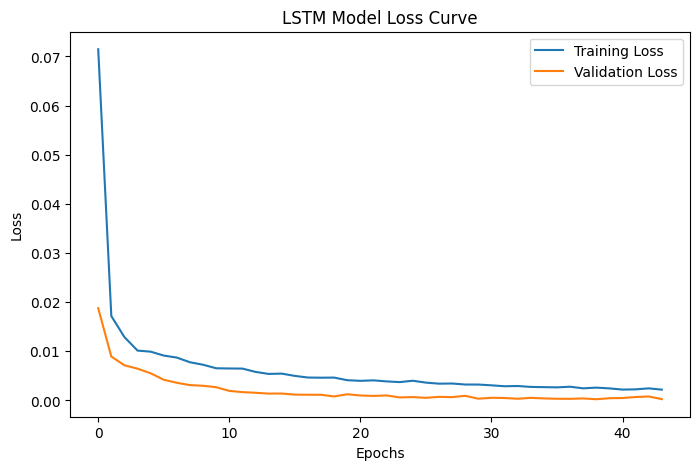

In [31]:
plot_loss_curve(lstm_history, "results/lstm_loss_curve.png", "LSTM")


In [32]:
from tensorflow.keras.models import load_model


In [36]:
def plot_results(true_values, predicted_values, filename="results/plot.png"):
    """
    Plots true vs predicted values (for the x-component as an example) and saves the figure.
    :param true_values: Array of true values.
    :param predicted_values: Array of predicted values.
    :param filename: File path to save the plot.
    """
    os.makedirs("results", exist_ok=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(true_values[:, 0], label="True x")
    plt.plot(predicted_values[:, 0], label="Predicted x", linestyle="--")
    plt.title("True vs Predicted x values")
    plt.legend()
    plt.savefig(filename)
    plt.show()
    print(f"✅ Plot saved to '{filename}'")


In [34]:
def visualize_model(model_path, data_path="data/processed_data.npz"):
    """
    Loads a saved model and processed test data, generates predictions,
    and plots the true vs predicted values.
    :param model_path: Path to the saved model file.
    :param data_path: Path to the processed data (.npz file).
    """
    # Check if processed data exists
    if not os.path.exists(data_path):
        print(f"❌ Processed data file not found at {data_path}.")
        return

    # Load processed test data.
    data = np.load(data_path)
    if "X_test" not in data or "y_test" not in data:
        print("❌ Processed data does not contain 'X_test' and 'y_test'.")
        return

    X_test = data["X_test"]
    y_test = data["y_test"]
    print(f"Loaded test data shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Check if model exists
    if not os.path.exists(model_path):
        print(f"❌ Model not found at {model_path}. Please train the model first.")
        return

    # Load the saved model.
    try:
        model = load_model(model_path)
        print(f"Loaded model from {model_path}")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return
    
    # Generate predictions.
    try:
        predicted = model.predict(X_test)
        print("Prediction completed successfully.")
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return

    # Verify that predictions have the correct shape.
    print(f"Predictions shape: {predicted.shape}")

    # Create a filename based on the model name.
    model_name = os.path.splitext(os.path.basename(model_path))[0]
    filename = f"results/{model_name}_predictions.png"
    
    # Plot and save the results.
    plot_results(y_test, predicted, filename=filename)


Loaded test data shapes: X_test: (2000, 10, 3), y_test: (2000, 3)
Loaded model from saved_models/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Prediction completed successfully.
Predictions shape: (2000, 3)


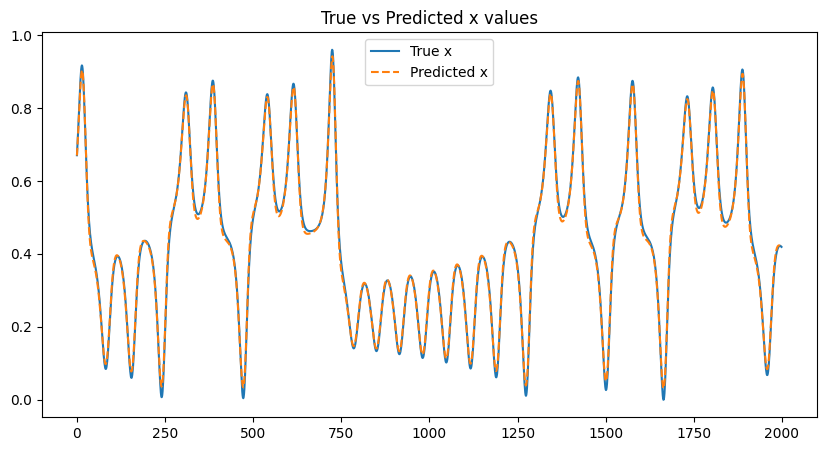

✅ Plot saved to 'results/lstm_model_predictions.png'


In [37]:
visualize_model("saved_models/lstm_model.h5")
